In [89]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import time

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress

#### Load Recipes Data

In [90]:
recipes = json.load(open('./data/recipe_train.json'))

# for dic in recipes:
#     ingredients = []
#     for ingredient in dic['ingredients']:
#         tmp_ingredient = ingredient.replace(' ', '-')
#         ingredients.append(tmp_ingredient)
#         dic['ingredients'] = ingredients

#### Convert recipe to text document

In [91]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [92]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

# vectorizer = TfidfVectorizer(use_idf=True, token_pattern=r"(?u)\b\w[\w-]*\w\b")
vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [93]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    # one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

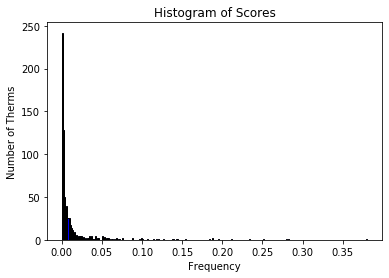

In [94]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [95]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    # print('-------------')
    # print(k)
    # print(scores_df.iloc[:15,:])


#### Load Baskets Market Data

In [96]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [97]:
top_scores_ngram = {}
CUISINE_TOP_SCORE_THRESHOLD = 0.1
for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>CUISINE_TOP_SCORE_THRESHOLD]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score, row['term']])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [98]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs.

But first, in order to optimize computation we first calculate ngrams of unique items.

In [99]:
items_ngrams = {}
for basket in baskets:
    for item in basket:
        if items_ngrams.get(item) is None :
            items_ngrams[item] = list(ngrams(row['term'], 3))

In [100]:
start_time = time.time()
baskets_scores = []
all_similarities = {}
for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        sims = 0
        for item in basket:      
            item_ngram = items_ngrams[item]
            for ngram_term, score, term in top_scores_ngram[cuisine]:
                if all_similarities.get(item+term) is None:
                    if all_similarities.get(term+item) is None:
                        sim = jaccard_distance(item_ngram, ngram_term)
                        all_similarities[item+term] = sim
                        all_similarities[term+item] = sim
                    else:
                        sim = all_similarities[term+item]
                else:
                    sim = all_similarities[item+term]

                if sim > 0.2:
                    value += sim * score
                    sims += sim
        if sims != 0:
            value = value/sims
        else:
            value=0
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 
baskets_scores_df = pd.DataFrame(baskets_scores)
baskets_scores_df=(baskets_scores_df-baskets_scores_df.mean())/baskets_scores_df.std()
print("--- %s seconds ---" % (time.time() - start_time))


--- 9.213142395019531 seconds ---


#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [103]:
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [104]:
# OPTICS
optics = OPTICS(min_samples=50, max_eps=0.1, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{0, 1, 2, 3, 4, 5, -1}


In [105]:
# K-Means
kMeans = KMeans(n_clusters=7, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6}


In [106]:
# DBSCAN 
[eps, min_samples] = [0.35, 200]
dbScan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])


{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
[0.35, 200]


#### Analysis of the method
Observe size of created basket clusters

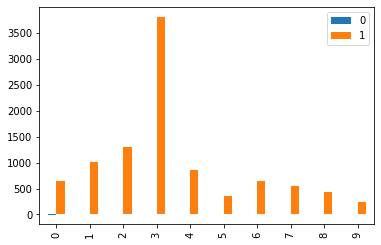

In [107]:
labels = dbScan_labels
cluster_sizes = []
for label in sorted(set(labels)):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [108]:
for selected_basket_cluster in set(labels):
    print("Cluster ", selected_basket_cluster)
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    print("#Baskets: ", selected_basket_scores.shape[0])
    aggregated_basket_cluster_score \
        = np.mean(selected_basket_scores, axis=0)\
        .sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)

Cluster  0
#Baskets:  1005
french          1.001307
irish           1.000097
cajun_creole    1.000048
korean          1.000037
vietnamese      1.000011
mexican         0.999899
spanish         0.999823
jamaican        0.999821
indian          0.999663
filipino        0.999606
russian         0.999570
british         0.998986
italian         0.997928
chinese        -0.999331
southern_us    -0.999697
greek          -0.999730
japanese       -0.999892
thai           -1.000191
brazilian      -1.000494
moroccan       -1.015509
dtype: float64
Cluster  1
#Baskets:  1299
french          1.000424
irish           1.000097
korean          1.000037
vietnamese      1.000011
mexican         0.999899
spanish         0.999823
jamaican        0.999821
indian          0.999663
filipino        0.999606
russian         0.999570
cajun_creole    0.998993
italian         0.997928
british         0.987762
chinese        -0.999331
southern_us    -0.999697
greek          -0.999730
japanese       -0.999892
thai  

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [109]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X_Baskets = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X_Baskets)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
for i in baseline_labels:
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 milk
 whole
 yogurt
 newspapers
 pastry
 coffee
 beverages
 soda
 sausage
 cheese
Cluster 1:
 rolls
 buns
 milk
 soda
 sausage
 whole
 bottled
 yogurt
 vegetables
 frankfurter
Cluster 2:
 canned
 beer
 soda
 rolls
 buns
 newspapers
 vegetables
 bottled
 wine
 fruit
Cluster 3:
 bottled
 soda
 beer
 water
 milk
 pastry
 whole
 wine
 liquor
 fruit
Cluster 4:
 fruit
 juice
 vegetable
 tropical
 pip
 citrus
 milk
 whole
 vegetables
 yogurt
Cluster 5:
 vegetables
 other
 root
 milk
 whole
 fruit
 frozen
 yogurt
 cheese
 beef
Cluster 6:
 cream
 sour
 whipped
 vegetables
 milk
 fruit
 whole
 ice
 other
 cheese
Cluster 7:
 chocolate
 specialty
 bar
 soda
 buns
 rolls
 marshmallow
 milk
 candy
 cheese
Cluster 8:
 shopping
 bags
 soda
 beer
 canned
 milk
 vegetables
 sausage
 buns
 rolls
Cluster 9:
 bread
 brown
 white
 milk
 whole
 vegetables
 semi
 finished
 fruit
 other


#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines 

In [110]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[model.labels_ == cluster]
    cluster_scores = np.mean(basket_scores,axis=0).sort_values()
    np.argsort(cluster_scores)
    print(cluster_scores)

moroccan       -1.007221
brazilian      -1.000184
thai           -1.000061
japanese       -0.999939
southern_us    -0.999897
greek          -0.999873
chinese        -0.999721
british         0.998978
italian         0.999177
russian         0.999801
indian          0.999818
filipino        0.999818
french          0.999836
jamaican        0.999901
spanish         0.999901
mexican         0.999931
vietnamese      0.999948
korean          0.999949
cajun_creole    0.999960
irish           0.999973
dtype: float64
moroccan       -1.004616
brazilian      -1.000255
thai           -1.000076
japanese       -0.999901
greek          -0.999817
southern_us    -0.999815
chinese        -0.999482
british         0.997956
filipino        0.999826
italian         0.999848
indian          0.999865
russian         0.999883
spanish         0.999941
jamaican        0.999944
vietnamese      0.999971
korean          0.999982
mexican         1.000017
cajun_creole    1.000034
irish           1.000065
french    